In [53]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import matplotlib.pyplot as plt  # 画图模块
import scipy.stats as stats # 统计模块
import scipy
from datetime import datetime # 时间模块
from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
import statsmodels.formula.api as smf  # OLS regression

#输出矢量图 渲染矢量图 是一个魔法函数（Magic Functions）内嵌绘图
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

我们要使用t−1月的指标对股票进行分组（一般分为10组），在不同的分组中，计算组内股票t月的加权平均收益率（或者简单平均收益率）

使用分组中最低组和最高组的差作为我们的投资组合，例如我们买入最高组的股票同时卖空最低组的股票（或者买入最低组卖空最高组，这个视指标和下一期收益率关系而定），这样我们自己的成本是零，但是我们可以通过这样的零成本，获得很高的收益

一般，我们将这种策略和大盘（市场）收益率进行对比，或者是Fama三因子、五因子等标准的定价因子对比。

In [54]:
cross = pd.read_csv('C:\Users\ignorance\Desktop\Python\数据\000001.csv')
cross['month'] = pd.to_datetime(cross['month'],format='%Y-%m-%d')
cross['to_v'] = pd.to_numeric(cross['to_v'])
cross['floatingvalue'] = pd.to_numeric(cross['floatingvalue'])
cross = cross.dropna(subset=['ret','next_ret'])
cross

,Stkcd,month,floatingvalue,totalvalue,Return,rfmonth,Rank,Freq,ret,next_ret,sizef,sizet,ew,Clsprc,beta_6m,N6m,beta_12m,N12m,bm,am,ep,to_v,fv,max1
0,1,1991-05-01,1.016010e+09,1.859497e+09,-0.122253,0.006092,2,24,-0.128345,-0.119551,20.739149,21.343572,1,38.34,4.192309,44.0,4.192309,44.0,NaN,NaN,NaN,0.007087,0.000804,-0.004883
1,1,1991-06-01,9.007350e+08,1.648521e+09,-0.113459,0.006092,3,23,-0.119551,-0.137013,20.618722,21.223144,1,33.99,0.246808,67.0,0.246808,67.0,NaN,NaN,NaN,0.001155,0.000895,0.004956
2,1,1991-07-01,7.828100e+08,1.432695e+09,-0.130921,0.006092,4,16,-0.137013,-0.417680,20.478401,21.082823,1,29.54,0.165424,83.0,0.165424,83.0,NaN,NaN,NaN,0.000230,0.001596,-0.004853
3,1,1991-08-01,6.748338e+08,1.346275e+09,-0.411588,0.006092,5,15,-0.417680,-0.039425,20.329977,21.020607,1,15.00,1.506699,98.0,1.506699,98.0,NaN,NaN,NaN,0.072087,0.240913,0.152896
4,1,1991-09-01,6.523394e+08,1.301399e+09,-0.033333,0.006092,6,24,-0.039425,0.849080,20.296075,20.986706,1,14.50,1.502630,122.0,1.502630,122.0,NaN,NaN,NaN,0.160940,0.005872,0.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604788,605589,2021-11-01,3.192953e+09,3.051846e+10,0.319156,0.001241,4,22,0.317915,-0.028913,21.884212,24.141598,1,39.39,2.063907,73.0,2.063907,73.0,0.259870,0.429465,NaN,1.812936,0.025807,0.077155
604790,605598,2021-10-01,5.874312e+08,2.349311e+09,-0.093937,0.001241,2,16,-0.095178,0.076700,20.191270,21.577388,1,13.60,1.221250,23.0,1.221250,23.0,0.612103,0.755971,NaN,1.345783,0.007366,0.040237
604791,605598,2021-11-01,6.332162e+08,2.532419e+09,0.077941,0.001241,3,22,0.076700,0.085389,20.266323,21.652441,1,14.66,1.053620,45.0,1.053620,45.0,0.567844,0.701310,NaN,1.263335,0.005363,0.031528
604793,605599,2021-10-01,9.076669e+08,9.076667e+09,-0.080378,0.001241,2,16,-0.081619,0.060456,20.626388,22.928973,1,11.67,1.339638,29.0,1.339638,29.0,0.342676,0.529242,NaN,0.970121,0.009502,0.034691


floatingvalue 为股票的月末流通市值  
totalvalue 为股票月末的总市值  
Return 为股票该月的考虑红利的收益率  
rfmonth 为该月的无风险收益率  
Rank 为该公司上市的第几个月份  
Freq 为该股票在该月的交易天数  
ret = Return - rfmonth  
next_ret 为该股票下一个月的ret  
sizef 为floatingvalue的自然对数  
sizet 为totalvalue的自然对数  
ew 为1  
Clsprc 为月末的收盘价  
beta_6m 使用t月至t−5月日交易数据  
beta_12m 使用t月至t−12月日交易数据  
bm 账面市值比，用t月的可以获得的账面价值 / t月的总市值  
ep 盈利市值比，用t月的可以获得的最近4个季度的盈利 / t月的总市值  
to_v t月基于交易量的换手率  
fv t月日收益率的波动率  
max1 t月日收益率的最大值  

In [55]:
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['Return'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))#每个月换手率做9个分位数
fenweishu

Return
month                   
1991-01-01 0.1  0.004899
           0.2  0.009798
           0.3  0.013602
           0.4  0.017406
           0.5  0.029248
...                  ...
2021-11-01 0.5  0.075000
           0.6  0.102908
           0.7  0.136170
           0.8  0.184897
           0.9  0.279377

[3339 rows x 1 columns]

In [56]:
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['to_v'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))#每个月换手率做9个分位数
fenweishu

to_v
month                   
1991-01-01 0.1  0.005358
           0.2  0.009574
           0.3  0.046878
           0.4  0.084182
           0.5  0.098841
...                  ...
2021-11-01 0.5  0.396191
           0.6  0.517241
           0.7  0.701620
           0.8  0.995704
           0.9  1.570376

[3339 rows x 1 columns]

In [57]:
fenweishu = fenweishu.reset_index()#去掉索引
fenweishu

,month,level_1,to_v
0,1991-01-01,0.1,0.005358
1,1991-01-01,0.2,0.009574
2,1991-01-01,0.3,0.046878
3,1991-01-01,0.4,0.084182
4,1991-01-01,0.5,0.098841
...,...,...,...
3334,2021-11-01,0.5,0.396191
3335,2021-11-01,0.6,0.517241
3336,2021-11-01,0.7,0.701620
3337,2021-11-01,0.8,0.995704


In [58]:
fenweishu = fenweishu.pivot_table(index='month',columns='level_1',values='to_v')#上面长表变宽表
fenweishu

level_1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
month,,,,,,,,,
1991-01-01,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571
1991-02-01,0.001583,0.011464,0.026130,0.033534,0.041987,0.058429,0.077645,0.096435,0.129484
1991-03-01,0.001035,0.003000,0.005408,0.007353,0.022131,0.047098,0.081336,0.160168,0.311436
1991-04-01,0.001474,0.001678,0.002029,0.003018,0.020541,0.072443,0.125600,0.128010,0.151429
1991-05-01,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048
...,...,...,...,...,...,...,...,...,...
2021-07-01,0.099615,0.158674,0.220071,0.287129,0.392639,0.522070,0.697323,0.979190,1.486739
2021-08-01,0.117002,0.176140,0.245320,0.335882,0.440232,0.580417,0.774479,1.082167,1.664888
2021-09-01,0.136273,0.197279,0.264552,0.332597,0.419407,0.532370,0.682228,0.911794,1.381652


In [59]:
kuanbiao=fenweishu
kuanbiao = kuanbiao.reset_index()#去掉索引

In [60]:
kuanbiao = kuanbiao.melt(id_vars=["month"],value_name='level_1',var_name='to_v')#上面宽表变长表
kuanbiao

,month,to_v,level_1
0,1991-01-01,0.1,0.005358
1,1991-02-01,0.1,0.001583
2,1991-03-01,0.1,0.001035
3,1991-04-01,0.1,0.001474
4,1991-05-01,0.1,0.007087
...,...,...,...
3334,2021-07-01,0.9,1.486739
3335,2021-08-01,0.9,1.664888
3336,2021-09-01,0.9,1.381652
3337,2021-10-01,0.9,0.872920


In [61]:
fenweishu.columns = ['one','two','three','four','five','six','seven','eight','nine']
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1991-01-01,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571
1991-02-01,0.001583,0.011464,0.026130,0.033534,0.041987,0.058429,0.077645,0.096435,0.129484
1991-03-01,0.001035,0.003000,0.005408,0.007353,0.022131,0.047098,0.081336,0.160168,0.311436
1991-04-01,0.001474,0.001678,0.002029,0.003018,0.020541,0.072443,0.125600,0.128010,0.151429
1991-05-01,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048
...,...,...,...,...,...,...,...,...,...
2021-07-01,0.099615,0.158674,0.220071,0.287129,0.392639,0.522070,0.697323,0.979190,1.486739
2021-08-01,0.117002,0.176140,0.245320,0.335882,0.440232,0.580417,0.774479,1.082167,1.664888
2021-09-01,0.136273,0.197279,0.264552,0.332597,0.419407,0.532370,0.682228,0.911794,1.381652


In [62]:
portfolio = pd.merge(cross,fenweishu,on='month')
portfolio

,Stkcd,month,floatingvalue,totalvalue,Return,rfmonth,Rank,Freq,ret,next_ret,sizef,sizet,ew,Clsprc,beta_6m,N6m,beta_12m,N12m,bm,am,ep,to_v,fv,max1,one,two,three,four,five,six,seven,eight,nine
0,1,1991-05-01,1.016010e+09,1.859497e+09,-0.122253,0.006092,2,24,-0.128345,-0.119551,20.739149,21.343572,1,38.34,4.192309,44.0,4.192309,44.0,NaN,NaN,NaN,0.007087,0.000804,-0.004883,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048
1,2,1991-05-01,3.161200e+08,4.656752e+08,-0.030901,0.006092,5,17,-0.036993,-0.309901,19.571632,19.958999,1,11.29,-84.718227,71.0,-84.718227,71.0,NaN,NaN,NaN,0.055375,0.001412,0.016379,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048
2,4,1991-05-01,4.950000e+07,1.237500e+08,-0.114490,0.006092,5,16,-0.120582,-0.460637,17.717483,18.633774,1,9.90,14.033671,62.0,14.033671,62.0,NaN,NaN,NaN,0.036300,0.002604,0.014563,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048
3,5,1991-05-01,4.502265e+08,9.495000e+08,-0.123026,0.006092,5,20,-0.129118,-0.115097,19.925261,20.671446,1,10.55,8.686426,77.0,8.686426,77.0,NaN,NaN,NaN,0.030158,0.001104,-0.004566,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048
4,600601,1991-05-01,3.576300e+07,3.930000e+07,-0.124722,0.006092,6,22,-0.130814,0.184748,17.392424,17.486735,1,39.30,0.998295,90.0,0.998295,90.0,0.270784,0.515407,0.012968,0.081956,0.002149,0.010499,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596105,600602,1991-01-01,2.479550e+08,1.010000e+09,0.009798,0.006930,2,22,0.002868,0.010496,19.328758,20.733216,1,505.00,0.985174,30.0,0.985174,30.0,0.294219,1.157426,0.022901,0.117475,0.000648,0.010097,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571
596106,600651,1991-01-01,1.324290e+07,1.324290e+07,0.000000,0.006930,2,20,-0.006930,-0.041567,16.398972,16.398972,1,401.30,1.002168,28.0,1.002168,28.0,0.162400,0.440908,0.036893,0.084182,0.000604,0.010116,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571
596107,600652,1991-01-01,1.756800e+06,1.756800e+06,0.062409,0.006930,2,11,0.055479,0.028134,14.379005,14.379005,1,219.60,27.225631,15.0,27.225631,15.0,NaN,NaN,NaN,0.113500,0.000332,0.010160,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571
596108,600654,1991-01-01,8.353800e+06,8.357778e+07,0.041089,0.006930,2,22,0.034159,0.081305,15.938227,18.241288,1,397.80,1747.783931,27.0,1747.783931,27.0,0.302221,1.365722,0.004276,0.157667,0.000733,0.010106,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571


In [63]:
portfolio['sort'] = np.where(
    portfolio['to_v'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['to_v'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['to_v'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['to_v'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['to_v'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['to_v'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['to_v'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['to_v'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['to_v'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio

,Stkcd,month,floatingvalue,totalvalue,Return,rfmonth,Rank,Freq,ret,next_ret,sizef,sizet,ew,Clsprc,beta_6m,N6m,beta_12m,N12m,bm,am,ep,to_v,fv,max1,one,two,three,four,five,six,seven,eight,nine,sort
0,1,1991-05-01,1.016010e+09,1.859497e+09,-0.122253,0.006092,2,24,-0.128345,-0.119551,20.739149,21.343572,1,38.34,4.192309,44.0,4.192309,44.0,NaN,NaN,NaN,0.007087,0.000804,-0.004883,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048,P1
1,2,1991-05-01,3.161200e+08,4.656752e+08,-0.030901,0.006092,5,17,-0.036993,-0.309901,19.571632,19.958999,1,11.29,-84.718227,71.0,-84.718227,71.0,NaN,NaN,NaN,0.055375,0.001412,0.016379,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048,P5
2,4,1991-05-01,4.950000e+07,1.237500e+08,-0.114490,0.006092,5,16,-0.120582,-0.460637,17.717483,18.633774,1,9.90,14.033671,62.0,14.033671,62.0,NaN,NaN,NaN,0.036300,0.002604,0.014563,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048,P3
3,5,1991-05-01,4.502265e+08,9.495000e+08,-0.123026,0.006092,5,20,-0.129118,-0.115097,19.925261,20.671446,1,10.55,8.686426,77.0,8.686426,77.0,NaN,NaN,NaN,0.030158,0.001104,-0.004566,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048,P2
4,600601,1991-05-01,3.576300e+07,3.930000e+07,-0.124722,0.006092,6,22,-0.130814,0.184748,17.392424,17.486735,1,39.30,0.998295,90.0,0.998295,90.0,0.270784,0.515407,0.012968,0.081956,0.002149,0.010499,0.007087,0.030158,0.036300,0.036500,0.055375,0.081273,0.081956,0.139454,0.178048,P7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596105,600602,1991-01-01,2.479550e+08,1.010000e+09,0.009798,0.006930,2,22,0.002868,0.010496,19.328758,20.733216,1,505.00,0.985174,30.0,0.985174,30.0,0.294219,1.157426,0.022901,0.117475,0.000648,0.010097,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571,P8
596106,600651,1991-01-01,1.324290e+07,1.324290e+07,0.000000,0.006930,2,20,-0.006930,-0.041567,16.398972,16.398972,1,401.30,1.002168,28.0,1.002168,28.0,0.162400,0.440908,0.036893,0.084182,0.000604,0.010116,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571,P4
596107,600652,1991-01-01,1.756800e+06,1.756800e+06,0.062409,0.006930,2,11,0.055479,0.028134,14.379005,14.379005,1,219.60,27.225631,15.0,27.225631,15.0,NaN,NaN,NaN,0.113500,0.000332,0.010160,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571,P6
596108,600654,1991-01-01,8.353800e+06,8.357778e+07,0.041089,0.006930,2,22,0.034159,0.081305,15.938227,18.241288,1,397.80,1747.783931,27.0,1747.783931,27.0,0.302221,1.365722,0.004276,0.157667,0.000733,0.010106,0.005358,0.009574,0.046878,0.084182,0.098841,0.113500,0.115487,0.117475,0.137571,Pmax


In [64]:
portfolio_turnover =  pd.DataFrame(
    portfolio.groupby(['month','sort']).apply(lambda x: np.average(x['next_ret'],weights = x['floatingvalue'])))
portfolio_turnover

0
month      sort          
1991-01-01 P1   -0.002070
           P2    0.038284
           P4   -0.041567
           P6    0.028134
           P8    0.010496
...                   ...
2021-11-01 P6    0.025703
           P7   -0.014737
           P8   -0.047624
           P9   -0.038053
           Pmax -0.056245

[3706 rows x 1 columns]

In [65]:
portfolio_turnover = portfolio_turnover.reset_index()
portfolio_turnover.columns = ['month', 'sort', 'p']
portfolio_turnover

,month,sort,p
0,1991-01-01,P1,-0.002070
1,1991-01-01,P2,0.038284
2,1991-01-01,P4,-0.041567
3,1991-01-01,P6,0.028134
4,1991-01-01,P8,0.010496
...,...,...,...
3701,2021-11-01,P6,0.025703
3702,2021-11-01,P7,-0.014737
3703,2021-11-01,P8,-0.047624
3704,2021-11-01,P9,-0.038053


In [66]:
portfolio_turnover = portfolio_turnover.pivot_table(index='month',
                                                    columns='sort',
                                                    values='p')
portfolio_turnover['My_portfolio'] = portfolio_turnover['P5'] - portfolio_turnover['Pmax']#长变宽
#每个月持有中间换手率10%的股票，卖空最大换手率10%的股票
portfolio_turnover

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1991-01-01,-0.002070,0.038284,NaN,-0.041567,NaN,0.028134,NaN,0.010496,NaN,0.081305,NaN
1991-02-01,0.023904,0.070941,-0.044343,-0.133504,-0.133293,-0.133253,-0.070455,-0.125264,-0.069140,-0.059149,-0.074144
1991-03-01,-0.123391,0.120035,-0.097744,-0.122736,-0.103582,-0.077512,0.087227,-0.133193,-0.000595,0.070484,-0.174066
1991-04-01,-0.129118,-0.036993,-0.120582,0.238572,-0.130814,0.202117,-0.006657,0.080639,-0.031989,0.055289,-0.186103
1991-05-01,-0.063342,-0.115097,-0.460637,0.166237,-0.309901,0.190283,0.184748,0.190006,0.177858,0.213185,-0.523086
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.028008,0.017727,-0.011599,0.025238,0.055045,0.042160,0.084119,0.038407,0.087948,0.105824,-0.050779
2021-08-01,0.068350,0.018683,0.029579,0.021552,-0.032494,-0.039072,-0.063207,-0.070873,-0.080577,-0.105075,0.072581
2021-09-01,0.008973,-0.006500,-0.007429,0.001049,0.004196,-0.014951,-0.017224,-0.027991,-0.018346,-0.005951,0.010147


In [67]:
portfolio_turnover = portfolio_turnover['1995-01':'2021-11'].copy()
portfolio_turnover['month'] = pd.date_range(start='1995-01', end='2021-12', freq='m')
#portfolio_turnover['month'] = pd.to_datetime(portfolio_turnover['month'],format = '%Y-%m-%d')
portfolio_turnover.set_index('month', inplace = True)
portfolio_turnover['My_portfolio'] = portfolio_turnover['My_portfolio'].shift(1)
portfolio_turnover['P5'] = portfolio_turnover['P5'].shift(1)
portfolio_turnover['Pmax'] = portfolio_turnover['Pmax'].shift(1)
portfolio_turnover

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-01-31,-0.022103,-0.017561,-0.032485,-0.022728,NaN,-0.037998,-0.008291,-0.020379,-0.017883,NaN,NaN
1995-02-28,0.032096,0.075105,0.112534,0.117928,-0.037434,0.135702,0.197283,0.194587,0.150353,-0.009641,-0.027793
1995-03-31,-0.099800,-0.123575,-0.104521,-0.104456,0.131727,-0.134205,-0.120331,-0.126251,-0.108062,0.219102,-0.087375
1995-04-30,0.027153,0.105400,0.207792,0.172384,-0.134321,0.170913,0.201840,0.225914,0.226737,-0.093994,-0.040327
1995-05-31,-0.070984,-0.066663,-0.073480,-0.098588,0.168134,-0.124651,-0.087616,-0.123379,-0.112577,0.293743,-0.125609
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,0.028008,0.017727,-0.011599,0.025238,-0.015479,0.042160,0.084119,0.038407,0.087948,0.017674,-0.033153
2021-08-31,0.068350,0.018683,0.029579,0.021552,0.055045,-0.039072,-0.063207,-0.070873,-0.080577,0.105824,-0.050779
2021-09-30,0.008973,-0.006500,-0.007429,0.001049,-0.032494,-0.014951,-0.017224,-0.027991,-0.018346,-0.105075,0.072581


In [68]:
model_port = smf.ols('My_portfolio ~ 1',
                 data=portfolio_turnover['2000-01':'2021-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 26 Nov 2022   Prob (F-statistic):                nan
Time:                        22:26:23   Log-Likelihood:                 473.01
No. Observations:                 263   AIC:                            -944.0
Df Residuals:                     262   BIC:                            -940.5
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0146      0.002      6.340      0.0

In [69]:
%%time
data = pd.read_csv('C:\Users\ignorance\Desktop\Python\数据\000001.csv')
data['Day'] = pd.to_datetime(data['Day'],format='%Y/%m/%d')
data.set_index('Day', inplace = True)
data.sort_values(by = ['Day'],axis=0, ascending=True)
data = data['1995-01':'2022-07'].copy()
data['Close'] = pd.to_numeric(data['Close'])
data['Preclose'] = pd.to_numeric(data['Preclose'])
data['Raw_return'] = data['Close'] / data['Preclose'] - 1
data['Log_return'] = np.log(data['Close']) - np.log(data['Preclose'])
data

CPU times: total: 172 ms
Wall time: 45.9 ms


,Preclose,Open,Highest,Lowest,Close,Volume,Money,Raw_return,Log_return
Day,,,,,,,,,
1995-01-03,647.87,637.72,647.71,630.53,639.88,23451800,1.806930e+08,-0.012333,-0.012409
1995-01-04,639.88,641.90,655.51,638.86,653.81,42222000,3.069230e+08,0.021770,0.021536
1995-01-05,653.81,655.38,657.52,645.81,646.89,43012300,3.015330e+08,-0.010584,-0.010641
1995-01-06,646.89,642.75,643.89,636.33,640.76,48748200,3.537580e+08,-0.009476,-0.009521
1995-01-09,640.76,637.52,637.55,625.04,626.00,50985100,3.985190e+08,-0.023035,-0.023305
...,...,...,...,...,...,...,...,...,...
2022-07-25,3269.97,3269.71,3273.18,3243.03,3250.39,27124574400,3.480000e+11,-0.005988,-0.006006
2022-07-26,3250.39,3254.19,3282.41,3246.04,3277.44,25946867600,3.340000e+11,0.008322,0.008288
2022-07-27,3277.44,3271.78,3282.57,3265.73,3275.76,24913148500,3.400000e+11,-0.000513,-0.000513


In [70]:
Month_data = data.resample('m')['Log_return'].sum().to_frame()
Month_data['Raw_return'] = np.exp(Month_data['Log_return']) - 1
Month_data

,Log_return,Raw_return
Day,,
1995-01-31,-0.141139,-0.131631
1995-02-28,-0.023979,-0.023694
1995-03-31,0.163651,0.177803
1995-04-30,-0.109315,-0.103552
1995-05-31,0.188901,0.207922
...,...,...
2022-03-31,-0.062604,-0.060685
2022-04-30,-0.065154,-0.063077
2022-05-31,0.044724,0.045739


In [71]:
MYPOR = portfolio_turnover[['P5','Pmax','My_portfolio']]
MYPOR = MYPOR.dropna()
MYPOR = MYPOR['2000-01':'2021-11']
MYPOR = pd.merge(MYPOR,Month_data[['Raw_return']],left_on='month',right_on='Day',how='left')
MYPOR['month'] = pd.date_range(start='2000-01', end='2021-12', freq='m')
MYPOR.set_index('month',inplace=True)
MYPOR

,P5,Pmax,My_portfolio,Raw_return
month,,,,
2000-01-31,0.154334,0.271388,-0.117053,0.123242
2000-02-29,0.119994,0.121918,-0.001924,0.116990
2000-03-31,0.102431,-0.014244,0.116675,0.049948
2000-04-30,-0.003553,-0.036702,0.033148,0.020053
2000-05-31,0.038875,0.038990,-0.000116,0.031710
...,...,...,...,...
2021-07-31,-0.015479,0.017674,-0.033153,-0.053976
2021-08-31,0.055045,0.105824,-0.050779,0.043145
2021-09-30,-0.032494,-0.105075,0.072581,0.006837


In [72]:
MYPOR['price_p5'] = np.exp(np.cumsum(np.log(MYPOR['P5']+1)))#cumsum累计和
MYPOR['price_pmax'] = np.exp(np.cumsum(np.log(MYPOR['Pmax']+1)))
MYPOR['price_portfolio'] = np.exp(np.cumsum(np.log(MYPOR['My_portfolio']+1)))
MYPOR['price_market'] = np.exp(np.cumsum(np.log(MYPOR['Raw_return']+1)))
MYPOR

,P5,Pmax,My_portfolio,Raw_return,price_p5,price_pmax,price_portfolio,price_market
month,,,,,,,,
2000-01-31,0.154334,0.271388,-0.117053,0.123242,1.154334,1.271388,0.882947,1.123242
2000-02-29,0.119994,0.121918,-0.001924,0.116990,1.292847,1.426393,0.881248,1.254650
2000-03-31,0.102431,-0.014244,0.116675,0.049948,1.425275,1.406074,0.984068,1.317318
2000-04-30,-0.003553,-0.036702,0.033148,0.020053,1.420210,1.354469,1.016688,1.343734
2000-05-31,0.038875,0.038990,-0.000116,0.031710,1.475420,1.407280,1.016570,1.386344
...,...,...,...,...,...,...,...,...
2021-07-31,-0.015479,0.017674,-0.033153,-0.053976,8.899766,0.151045,36.426033,2.486031
2021-08-31,0.055045,0.105824,-0.050779,0.043145,9.389653,0.167029,34.576338,2.593291
2021-09-30,-0.032494,-0.105075,0.072581,0.006837,9.084550,0.149478,37.085924,2.611022


CPU times: total: 203 ms
Wall time: 206 ms


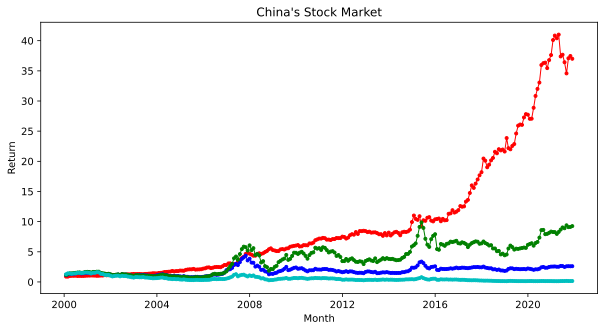

In [73]:
%%time
fig = plt.figure(figsize=(10, 5))
plt.plot(
    'price_portfolio',  
    '.-r', 
    label='Price of My Portfolio',  
    linewidth=1, 
    data=MYPOR)  
plt.title("China's Stock Market") 
plt.xlabel('Month') 
plt.ylabel('Return') 

plt.plot(
    'price_market', 
    '.-b', 
    label='Price of Market', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_p5', 
    '.-g', 
    label='Price of Lowest', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_pmax', 
    '.-c', 
    label='Price of Highest', 
    linewidth=1, 
    data=MYPOR) 

fig = plt.gcf()
fig.savefig('portfolio.pdf', bbox_inches='tight')